In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

In [2]:
## Helper functions

def lin_reg_by_hand(fit_x,fit_y):
    tot_fit = np.concatenate([fit_x,fit_y],axis=1)
    n_x = fit_x.shape[1]
   
    fit_mu = np.mean(tot_fit,axis=0)
    fit_sig = np.cov(tot_fit,rowvar=False)
   
    x_mu = fit_mu[:n_x]
    x_sig = fit_sig[:n_x, :n_x]
   
    y_mu = fit_mu[n_x:]
    y_sig = fit_sig[n_x:, n_x:]
   
    cross_cov_y_x = fit_sig[n_x:, :n_x]
    cross_cov_x_y = cross_cov_y_x.transpose()

    beta = cross_cov_y_x @ np.linalg.inv(x_sig)

    return fit_mu,fit_sig,x_mu,x_sig,y_mu,y_sig,cross_cov_y_x,cross_cov_x_y,beta

def cov_to_corr(cov_matrix):
    std_devs = np.sqrt(np.diag(cov_matrix))    
    return cov_matrix[0,1] / (std_devs[0] * std_devs[1])

def entropy_by_hand(p):
    return (-p*np.log2(p)).sum(axis=1)

def evaluate_bivariate_normal_pdf(x, y, mu_x, mu_y, sigma_x, sigma_y, rho, norm_it):
    inputs = [x, y, mu_x, mu_y, sigma_x, sigma_y, rho]
    inputs = [np.asarray(i) for i in inputs]

    valid_mask = np.all([np.isfinite(i) for i in inputs], axis=0)
   
    pdf = np.full_like(x, np.nan, dtype=float)
   
    x_valid, y_valid = x[valid_mask], y[valid_mask]
    mu_x_valid, mu_y_valid = mu_x[valid_mask], mu_y[valid_mask]
    sigma_x_valid, sigma_y_valid = sigma_x[valid_mask], sigma_y[valid_mask]
    rho_valid = rho[valid_mask]
   
    coeff = 1 / (2 * np.pi * sigma_x_valid * sigma_y_valid * np.sqrt(1 - rho_valid**2))
   
    z_x = (x_valid - mu_x_valid) / sigma_x_valid
    z_y = (y_valid - mu_y_valid) / sigma_y_valid
   
    exponent = -(z_x**2 - 2*rho_valid*z_x*z_y + z_y**2) / (2 * (1 - rho_valid**2))
   
    pdf[valid_mask] = coeff * np.exp(exponent)

    if norm_it:
        z_x_max = np.zeros_like(mu_x_valid)
        z_y_max = np.zeros_like(mu_y_valid)
        exponent_max = -(z_x_max**2 - 2*rho_valid*z_x_max*z_y_max + z_y_max**2) / (2 * (1 - rho_valid**2))
        max_pdf = coeff * np.exp(exponent_max)
        pdf[valid_mask] /= max_pdf
   
    return pdf,valid_mask

def bivariate_normal_pdf_by_hand_polars(df,test_cols,group_cols,result_description,input_description):
    
    metric_one = test_cols[0]
    metric_two = test_cols[1]

    corr_df = (
        df
        .filter(pl.len().over(group_cols)>=2)
        .filter(~pl.col(metric_one).is_nan())
        .filter(~pl.col(metric_two).is_nan())
        .group_by(group_cols)
        .agg(
            pl.mean(metric_one).alias(f"{input_description}_{metric_one}_mu"),
            pl.var(metric_one).alias(f"{input_description}_{metric_one}_var"),
            pl.std(metric_one).alias(f"{input_description}_{metric_one}_std"),
            pl.mean(metric_two).alias(f"{input_description}_{metric_two}_mu"),
            pl.var(metric_two).alias(f"{input_description}_{metric_two}_var"),
            pl.std(metric_two).alias(f"{input_description}_{metric_two}_std"),
            pl.cov(metric_one,metric_two).alias(f"{input_description}_{metric_one}_{metric_two}_cov"),
            pl.len().alias("n"),
        )
    )
    
    corr_df = corr_df.with_columns(
        (
            pl.col(f"{input_description}_{metric_one}_{metric_two}_cov") / 
            (pl.col(f"{input_description}_{metric_one}_var").sqrt() * pl.col(f"{input_description}_{metric_two}_var").sqrt())
        )
        .alias(f"{input_description}_{metric_one}_{metric_two}_corr")
    )

    df = df.drop(columns=[col for col in corr_df.columns if col not in group_cols and col not in ["n"]])
    df = df.join(
        corr_df.drop(columns=["n"]),
        on=group_cols,
        how="left"
    )

    mean_cols = [f"{input_description}_{metric_one}_mu",f"{input_description}_{metric_two}_mu"]
    std_cols = [f"{input_description}_{metric_one}_std",f"{input_description}_{metric_two}_std"]
    corr_col = f"{input_description}_{metric_one}_{metric_two}_corr"

    observed_point = [metric_one,metric_two]

    pdf_values, valid_mask = evaluate_bivariate_normal_pdf(
        x=pd.Series(df[observed_point[0]]).astype(float).values,
        y=pd.Series(df[observed_point[1]]).astype(float).values,
        mu_x=pd.Series(df[mean_cols[0]]).astype(float).values,
        mu_y=pd.Series(df[mean_cols[1]]).astype(float).values,
        sigma_x=pd.Series(df[std_cols[0]]).astype(float).values,
        sigma_y=pd.Series(df[std_cols[1]]).astype(float).values,
        rho=pd.Series(df[corr_col]).astype(float).values,
        norm_it=True
    )

    df = df.with_columns(
        pl.Series(name=f"{input_description}{result_description}",values=pdf_values)
    )
    
    return df

In [3]:
df = (
    pd.read_csv(r"./arm_angle_kaggle/train.csv")
    .dropna(subset=["release_speed","release_extension"])
    .drop(columns=["index"])
    .reset_index(drop=True)
)

In [4]:
df.head()

,pitch_type,pitch_name,on_3b,on_2b,on_1b,inning,inning_topbot,outs_when_up,balls,strikes,...,release_speed,release_pos_x,release_extension,release_pos_z,release_spin_rate,spin_axis,bat_speed,swing_length,is_strike,k
0,SL,Slider,False,True,False,8,Top,0,0,2,...,92.0,-2.77,6.2,6.50,2461.0,183.0,NaN,NaN,0,0
1,FF,4-Seam Fastball,False,True,False,4,Top,2,3,2,...,96.1,1.90,6.8,6.71,2452.0,158.0,65.6,6.1,0,0
2,SL,Slider,False,False,False,7,Top,1,1,2,...,87.7,-1.84,5.9,5.14,2883.0,46.0,NaN,NaN,0,0
3,SL,Slider,True,False,True,2,Bot,2,0,0,...,87.0,-1.22,6.4,5.50,2257.0,176.0,NaN,NaN,0,0
4,SI,Sinker,False,True,True,7,Top,2,0,0,...,93.0,1.81,6.5,5.39,2229.0,129.0,NaN,NaN,0,0


In [5]:
def additional_columns_one(df):
    # simple data cleaning on arm angle
    df["arm_angle_observed"] = df["arm_angle"].replace("--",np.nan).astype(float).values

    # use expected arm angle for missing data points
    x_vars = ["release_pos_x","release_pos_z","release_extension"]
    y_vars = ["arm_angle_observed"]
   
    fit_mu,fit_sig,x_mu,x_sig,y_mu,y_sig,cross_cov_y_x,cross_cov_x_y,beta = lin_reg_by_hand(
        fit_x = df.dropna(subset=x_vars+y_vars)[x_vars].to_numpy(),
        fit_y = df.dropna(subset=x_vars+y_vars)[y_vars].to_numpy(),
    )
   
    df["arm_angle_expected"] = y_mu + (df[x_vars] - x_mu) @ beta.T
    df["arm_angle_final"] = df["arm_angle_observed"].fillna(df["arm_angle_expected"]).fillna(np.nanmean(df["arm_angle_observed"]))

    # flip sign based on batter and pitcher handedness
    for col in ["pfx_x","release_pos_x"]:
        df[f"{col}_pit_flip"] = np.where(df["p_throws"]=="R",df[col].mul(-1),df[col])
        df[f"{col}_bat_flip"] = np.where(df["stand"]=="L",df[col].mul(-1),df[col])

    # horz and vert as popularly understood (flipped for pitcher handedness and in units of inches)
    df["horz"] = df["pfx_x_pit_flip"].mul(12)
    df["vert"] = df["pfx_z"].mul(12)

    # determines movement angle and angle relative to arm angle
    df["movement_angle"] = ((np.degrees(np.arctan2(df["horz"],df["vert"])) + 90)%360).astype(float)
    df["movement_angle_delta"] = df["movement_angle"].values - df["arm_angle_final"].values

    # total movement
    df["total_break"] = (df["horz"].values**2 + df["vert"].values**2)**0.5

    # creates integer versions of the on base columns (used later when modeling)
    for col in [_ for _ in df.columns if _.startswith("on_") and _.endswith("b")]:
        df[f"{col}_int"] = df[col].astype(int)

    df["pitch_group"] = np.where(
        df["pitch_type"].isin(["FF","SI"]),
        "fastball",
        np.where(
            df["pitch_type"].isin(["ST","SL","KC","CU"]),
            "bendy",
            np.where(
                df["pitch_type"].isin(["FS","CH","FC"]),
                "offspeed",
                "other"
            )
        )
    )

    return df

In [6]:
df = additional_columns_one(df)

In [7]:
"""
Using a GMM to fit pitch types rather than observed types, with the hope that this better
aligns with batters' interactions with various pitch types. For example, using actual pitch
types makes it tricky for someone like Josh Hader and his SI.

"""

from sklearn.mixture import GaussianMixture

pred_vars = ["release_speed","horz","vert","movement_angle_delta"]
fit_x = df[pred_vars].dropna().to_numpy()

pitch_cluster_model = GaussianMixture(n_components=10, random_state=3024)
pitch_cluster_model.fit(fit_x)

pred_data = df[pred_vars].dropna()
pred_ind = pred_data.index
modeled_types = pitch_cluster_model.predict(pred_data)
modeled_probs = pitch_cluster_model.predict_proba(pred_data)

# Assign clusters and cluster weights
df["pitch_cluster"] = np.nan
df.loc[pred_ind,"pitch_cluster"] = modeled_types
df["pitch_cluster"] = df["pitch_cluster"].astype(int)

for i, pred_type in enumerate(np.arange(modeled_probs.shape[1])):
    df[f"cluster_{i}_weight"] = np.nan
    df.loc[pred_ind,f"cluster_{i}_weight"] = modeled_probs[:,i]

In [8]:
(
    df[["pitch_cluster"]+pred_vars]
    .groupby(["pitch_cluster"])
    .mean().round(2)
    .reset_index()
    .merge(
        df[["pitch_cluster","pitch_type"]].groupby("pitch_cluster").agg(pd.Series.mode).reset_index(),
    )
    .set_index("pitch_cluster")
    .rename(columns={"pitch_type":"most_common_pitch_type"})
)

,release_speed,horz,vert,movement_angle_delta,most_common_pitch_type
pitch_cluster,,,,,
0,83.37,-10.22,-2.57,308.53,SL
1,94.68,8.84,16.53,77.35,FF
2,88.22,-2.73,6.17,25.38,FC
3,85.58,6.13,-1.27,172.58,SI
4,80.40,-7.99,-10.08,261.34,CU
5,90.80,15.27,4.93,129.80,SI
6,82.11,2.04,8.97,63.64,FC
7,83.35,-10.43,3.11,-16.92,SL
8,93.04,2.95,14.55,56.40,FF


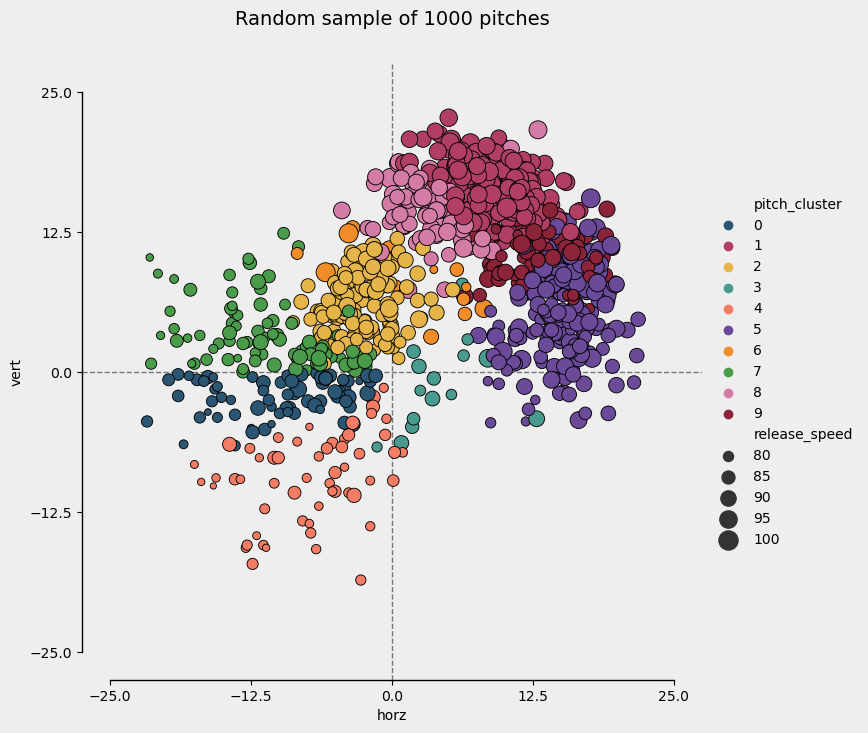

In [9]:
# visualize the clusters

import seaborn as sns
import matplotlib.pyplot as plt

COLOR_DICT = {
    "BLUE": "#2a5674",
    "RED": "#b13f64",
    "GOLD": "#e6b54a",
    "TEAL": "#4a9b8f",
    "CORAL": "#f47c65",
    "PURPLE": "#6a4a99",
    "ORANGE": "#f28c28",
    "GREEN": "#4a9b4a",
    "PINK": "#d47ca6",
    "MAROON": "#8b2439",
}

colors = [COLOR_DICT[color] for color in COLOR_DICT.keys()]

fig,ax=plt.subplots(figsize=(8,8),facecolor="#eeeeee")

sample_size=1000

sns.scatterplot(
    data = df.query("""release_speed>=75""").sample(sample_size),
    x="horz",
    y="vert",
    hue="pitch_cluster",
    size="release_speed",
    sizes=(20, 200),
    palette = colors,
    ax=ax,
    edgecolor="black",
)

ax.legend(loc="center left",bbox_to_anchor=(1,0.5),facecolor="#eeeeee",frameon=False,)

ticks = np.linspace(-25,25,5)
ax.set(
    facecolor="#eeeeee",
    xlim=(-27.5,27.5),
    ylim=(-27.5,27.5),
    xticks=ticks,
    yticks=ticks,
)

ax.axhline(0,color='black',lw=1,zorder=0,linestyle="--",alpha=0.5,)
ax.axvline(0,color='black',lw=1,zorder=0,linestyle="--",alpha=0.5,)

sns.despine()
spines = ["bottom","left"]
ax.spines[spines].set_visible(True)
ax.spines[spines].set_color('black')
ax.spines[spines].set_linewidth(1)
ax.spines[spines].set_bounds(-25,25)

ax.set_title(f"Random sample of {sample_size} pitches",fontsize=14,y=1.05)

plt.show()

In [10]:
"""
Just like DDZ but using the clusters from above rather than observed
pitch types. So E[cluster|arm_angle,extension].

"""

from sklearn.linear_model import LogisticRegression

x_vars = ["arm_angle_final","release_extension"]
y_vars = ["pitch_cluster"]

fit_x = df.dropna(subset=x_vars+y_vars)[x_vars]
fit_y = df.dropna(subset=x_vars+y_vars)[y_vars]

exp_cluster_model = LogisticRegression(multi_class="multinomial",random_state=3024)
exp_cluster_model.fit(fit_x, fit_y)

pred_data = df[x_vars].dropna()
pred_ind = pred_data.index

pred_types = exp_cluster_model.predict(pred_data)
pred_probs = exp_cluster_model.predict_proba(pred_data)

# determine predicted pitch cluster and pitch cluster probabilities
df["pred_pitch_cluster"] = np.nan
df.loc[pred_ind,"pred_pitch_cluster"] = pred_types
df["pred_pitch_cluster"] = df["pred_pitch_cluster"].astype(int)

for i, pred_type in enumerate(exp_cluster_model.classes_):
    df[f"cluster_{i}_pred"] = np.nan
    df.loc[pred_ind,f"cluster_{i}_pred"] = pred_probs[:,i]
    df[f"weighted_cluster_{i}_probability"] = df[f"cluster_{i}_pred"]*df[f"cluster_{int(i)}_weight"]

# determine how surprising the given pitch cluster was and the entropy of the pitch cluster probability vector
df["weighted_cluster_probability"] = df[[col for col in df.columns if col.startswith("weighted_cluster_") and col.endswith("_probability")]].sum(axis="columns")
df["cluster_entropy"] = entropy_by_hand(df[[col for col in df.columns if col.startswith("cluster_") and col.endswith("_pred")]].to_numpy())

df["cluster_probability"] = np.select(
    [df["pitch_cluster"] == pt for pt in df["pitch_cluster"].unique()],
    [df[f"cluster_{i}_pred"].fillna(0) for i in df["pitch_cluster"].unique()],
    default=np.nan)

In [11]:
# unexpected horz and vert
# again this is just like as laid out in the mathematical explainer for DDZ

for i, cluster in enumerate(df["pitch_cluster"].dropna().unique()):
    # for each pitch cluster determine the expected movement given arm angle and release extension (basically DDZ)
    clust_ = df.loc[(df["pitch_cluster"]==cluster)]
    x_vars = ["arm_angle_final","release_extension"]
    y_vars = ["horz","vert"]
   
    fit_mu,fit_sig,x_mu,x_sig,y_mu,y_sig,cross_cov_y_x,cross_cov_x_y,beta = lin_reg_by_hand(
        fit_x = clust_.dropna(subset=x_vars+y_vars)[x_vars].to_numpy(),
        fit_y = clust_.dropna(subset=x_vars+y_vars)[y_vars].to_numpy(),
    )
   
    pred_mu = y_mu + (df[x_vars] - x_mu) @ beta.T
    pred_sig = y_sig - beta @ cross_cov_x_y

    # predicted movement means, sigmas, and rho
    df[[f"cluster_{cluster}_pred_mu_{y_vars[0]}",f"cluster_{cluster}_pred_mu_{y_vars[1]}"]] = pred_mu
    df[f"cluster_{cluster}_pred_var_{y_vars[0]}"] = pred_sig[0,0]
    df[f"cluster_{cluster}_pred_var_{y_vars[1]}"] = pred_sig[1,1]
    df[f"cluster_{cluster}_pred_corr_{y_vars[0]}_{y_vars[1]}"] = cov_to_corr(pred_sig)

    # movement relative to expected given cluster
    df[f"cluster_{cluster}_unexpected_{y_vars[0]}"] = df[y_vars[0]]-df[f"cluster_{cluster}_pred_mu_{y_vars[0]}"]
    df[f"cluster_{cluster}_unexpected_{y_vars[1]}"] = df[y_vars[1]]-df[f"cluster_{cluster}_pred_mu_{y_vars[1]}"]

    # movement relative to expected given cluster weighted by that cluster's weight from GMM
    df[f"cluster_{cluster}_unexpected_{y_vars[0]}_weighted"] = (df[y_vars[0]]-df[f"cluster_{cluster}_pred_mu_{y_vars[0]}"])*df[f"cluster_{int(cluster)}_weight"]
    df[f"cluster_{cluster}_unexpected_{y_vars[1]}_weighted"] = (df[y_vars[1]]-df[f"cluster_{cluster}_pred_mu_{y_vars[1]}"])*df[f"cluster_{int(cluster)}_weight"]

# final unexpected movement is the summed weighted unexpected movement
df["weighted_unexpected_horz"] = df[[col for col in df.columns if "unexpected_horz_weighted" in col]].sum(axis="columns")
df["weighted_unexpected_vert"] = df[[col for col in df.columns if "unexpected_vert_weighted" in col]].sum(axis="columns")

for metric in ["horz","vert"]:
    df[f"pred_mu_{metric}"] = np.select(
        [df["pitch_cluster"] == pt for pt in df["pitch_cluster"].unique()],
        [df[f"cluster_{i}_pred_mu_{metric}"].fillna(0) for i in df["pitch_cluster"].unique()],
        default=np.nan)
    df[f"pred_var_{metric}"] = np.select(
        [df["pitch_cluster"] == pt for pt in df["pitch_cluster"].unique()],
        [df[f"cluster_{i}_pred_var_{metric}"].fillna(0) for i in df["pitch_cluster"].unique()],
        default=np.nan)

    df[f"unexpected_{metric}"] = df[metric]-df[f"pred_mu_{metric}"]

df[f"pred_corr_horz_vert"] = np.select(
    [df["pitch_cluster"] == pt for pt in df["pitch_cluster"].unique()],
    [df[f"cluster_{i}_pred_corr_horz_vert"].fillna(0) for i in df["pitch_cluster"].unique()],
    default=np.nan)

In [12]:
# movement surprise
for cluster in df["pitch_cluster"].unique():  
    # fit multivariate normal pdf on predicted movement for the given pitch cluster, then evaluate it at the observed movement
    mean_cols = [f"cluster_{cluster}_pred_mu_horz",f"cluster_{cluster}_pred_mu_vert"]
    std_cols = [f"cluster_{cluster}_pred_var_horz",f"cluster_{cluster}_pred_var_vert"]
    corr_col = f"cluster_{cluster}_pred_corr_horz_vert"
   
    observed_point =["horz", "vert"]

    pdf_values, valid_mask = evaluate_bivariate_normal_pdf(
        x=df[observed_point[0]].astype(float).values,
        y=df[observed_point[1]].astype(float).values,
        mu_x=df[mean_cols[0]].astype(float).values,
        mu_y=df[mean_cols[1]].astype(float).values,
        sigma_x=df[std_cols[0]].astype(float).values**0.5,
        sigma_y=df[std_cols[1]].astype(float).values**0.5,
        rho=df[corr_col].astype(float).values,
        norm_it = True
    )
   
    df[f"{cluster}_movement_pdf"] = pdf_values

# goes from individual mvnormal pdfs to one mixture of mvnormals weighted first by predicted pitch cluster,
# then by pitch cluster weight, then purely by observed cluster
# Finally determines how surprising the movement was based on that mixture of mvnormals

df["movement_pdf_given_release"] = 0.0
for cluster in df["pitch_cluster"].unique():
    df["movement_pdf_given_release"] += (df[f"cluster_{int(cluster)}_pred"].fillna(0)*df[f"{cluster}_movement_pdf"].fillna(0))
df["movement_surprise_given_release"] = -np.log(np.maximum(df["movement_pdf_given_release"],1e-300))

df["movement_pdf_given_cluster_weighted"] = 0.0
for cluster in df["pitch_cluster"].unique():
    df["movement_pdf_given_cluster_weighted"] += (df[f"cluster_{int(cluster)}_weight"].fillna(0)*df[f"{cluster}_movement_pdf"].fillna(0))
df["movement_surprise_given_cluster_weighted"] = -np.log(np.maximum(df["movement_pdf_given_cluster_weighted"],1e-300))

df["movement_pdf_given_cluster"] = np.select(
    [df["pitch_cluster"] == pt for pt in df["pitch_cluster"].unique()],
    [df[f"{i}_movement_pdf"].fillna(0) for i in df["pitch_cluster"].unique()],
    default=np.nan)
df["movement_surprise_given_cluster"] = -np.log(np.maximum(df["movement_pdf_given_cluster"],1e-300))

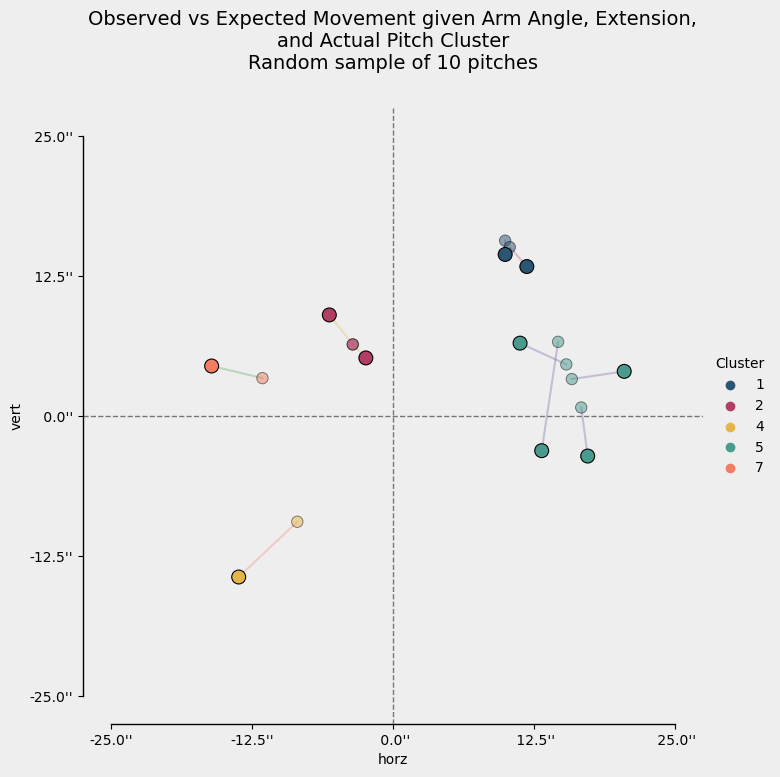

In [13]:
fig, ax = plt.subplots(figsize=(8,8), facecolor="#eeeeee")
sample_size = 10
plot_data = df.query("""release_speed>=75""").sample(sample_size)

for idx, row in plot_data.iterrows():
    ax.plot(
        [row["horz"], row["pred_mu_horz"]], 
        [row["vert"], row["pred_mu_vert"]], 
        color=colors[row["pitch_cluster"]], 
        alpha=0.3, 
        linestyle="-", 
        zorder=1,
        label=None,
    ) 

sns.scatterplot(
    data=plot_data,
    x="horz",
    y="vert",
    hue="pitch_cluster",
    palette=colors,
    edgecolor="black",
    s=100,
    ax=ax,
    zorder=3,
)

sns.scatterplot(
    data=plot_data,
    x="pred_mu_horz",
    y="pred_mu_vert",
    hue="pitch_cluster",
    palette=colors,
    edgecolor="black",
    s=66.7,
    ax=ax,
    alpha=0.5,
    zorder=2,
    label=None,
    legend=False,
)

ax.legend(loc="center left", bbox_to_anchor=(1,0.5), facecolor="#eeeeee", frameon=False,title="Cluster")
ticks = np.linspace(-25,25,5)
tick_labels = [f"""{tick: 0.1f}''""" for tick in ticks]
ax.set(
    facecolor="#eeeeee",
    xlim=(-27.5,27.5),
    ylim=(-27.5,27.5),
    xticks=ticks,
    yticks=ticks,
    xticklabels=tick_labels,
    yticklabels=tick_labels,
)

ax.axhline(0, color="black", lw=1, zorder=0, linestyle="--", alpha=0.5)
ax.axvline(0, color="black", lw=1, zorder=0, linestyle="--", alpha=0.5)
sns.despine()
ax.spines[["bottom","left"]].set_visible(True)
ax.spines[["bottom","left"]].set_color("black")
ax.spines[["bottom","left"]].set_linewidth(1)
ax.spines[["bottom","left"]].set_bounds(-25,25)
ax.set_title(
    f"""Observed vs Expected Movement given Arm Angle, Extension,
and Actual Pitch Cluster
Random sample of {sample_size} pitches""", 
    fontsize=14, 
    y=1.05,
)

plt.show()

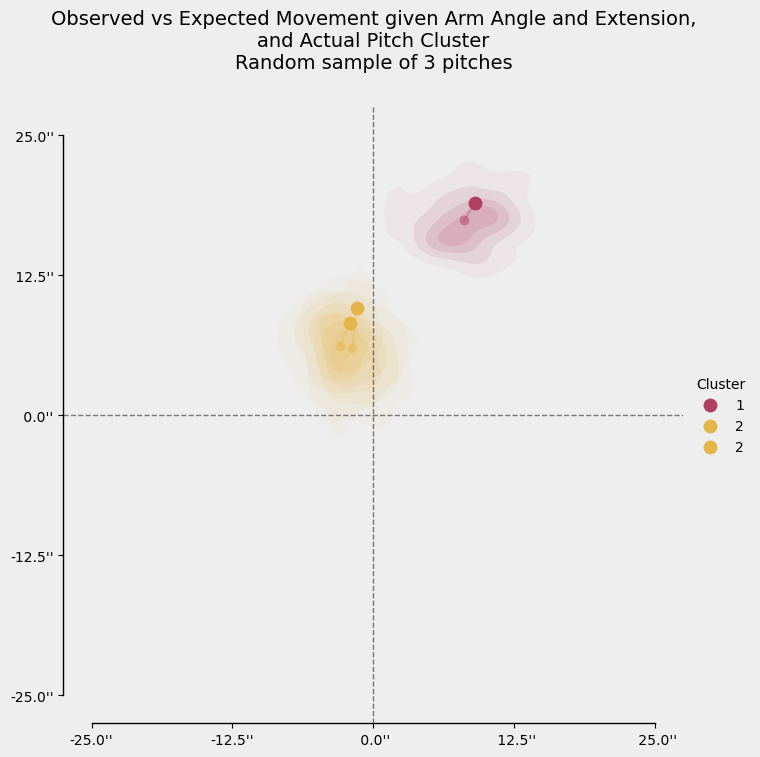

In [14]:
cluster_colors = {}
for i,key in enumerate(COLOR_DICT.keys()):
    cluster_colors[i]=COLOR_DICT[key]

from matplotlib.colors import LinearSegmentedColormap
import matplotlib

fig, ax = plt.subplots(figsize=(8,8), facecolor="#eeeeee")
sample_size = 3
plot_data = df.query("""release_speed>=75""").sample(sample_size)

for idx, row in plot_data.iterrows():
    ax.plot(
        [row["horz"], row["pred_mu_horz"]], 
        [row["vert"], row["pred_mu_vert"]], 
        color=colors[row["pitch_cluster"]], 
        alpha=0.3, 
        linestyle="-", 
        zorder=1,
        label=None,
    ) 
    
    sns.scatterplot(
        x=[row["horz"]],
        y=[row["vert"]],
        color=cluster_colors[row["pitch_cluster"]],
        edgecolor="black",
        s=100,
        ax=ax,
        zorder=3,
        label=row["pitch_cluster"],
    )

    sns.scatterplot(
        x=[row["pred_mu_horz"]],
        y=[row["pred_mu_vert"]],
        color=cluster_colors[row["pitch_cluster"]],
        edgecolor="black",
        alpha=0.5,
        s=50,
        ax=ax,
        zorder=3,
        label=None,
    )

    n_levels = 5    
    color = cluster_colors[row["pitch_cluster"]]
    cmap = LinearSegmentedColormap.from_list(
        "",
        [(0, (*matplotlib.colors.to_rgb(color), 0)),
         (1, (*matplotlib.colors.to_rgb(color), 0.4))]
    )

    random_sample = np.random.multivariate_normal(
        mean=[
            row[f"pred_mu_horz"],
            row[f"pred_mu_vert"]
        ],
        cov=[
            [row[f"pred_var_horz"], 
             row[f"pred_corr_horz_vert"]],
            [row[f"pred_corr_horz_vert"],
             row[f"pred_var_vert"]]
        ],
        size=100
    )
   
    kde = sns.kdeplot(
        x=random_sample[:,0],
        y=random_sample[:,1],
        fill=True,
        ax=ax,
        levels=np.linspace(0.1,1,n_levels),
        cmap=cmap,
        zorder=0,
        lw=0.01,
    )

    for collection in kde.collections:
        collection.set_edgecolor("#eeeeee")
        collection.set_linewidth(0.01)

ax.legend(loc="center left", bbox_to_anchor=(1,0.5), facecolor="#eeeeee", frameon=False,title="Cluster")
ticks = np.linspace(-25,25,5)
tick_labels = [f"""{tick: 0.1f}''""" for tick in ticks]
ax.set(
    facecolor="#eeeeee",
    xlim=(-27.5,27.5),
    ylim=(-27.5,27.5),
    xticks=ticks,
    yticks=ticks,
    xticklabels=tick_labels,
    yticklabels=tick_labels,
)

ax.axhline(0, color="black", lw=1, zorder=0, linestyle="--", alpha=0.5)
ax.axvline(0, color="black", lw=1, zorder=0, linestyle="--", alpha=0.5)
sns.despine()
ax.spines[["bottom","left"]].set_visible(True)
ax.spines[["bottom","left"]].set_color("black")
ax.spines[["bottom","left"]].set_linewidth(1)
ax.spines[["bottom","left"]].set_bounds(-25,25)
ax.set_title(
    f"""Observed vs Expected Movement given Arm Angle and Extension,
and Actual Pitch Cluster
Random sample of {sample_size} pitches""", 
    fontsize=14, 
    y=1.05,
)

plt.show()

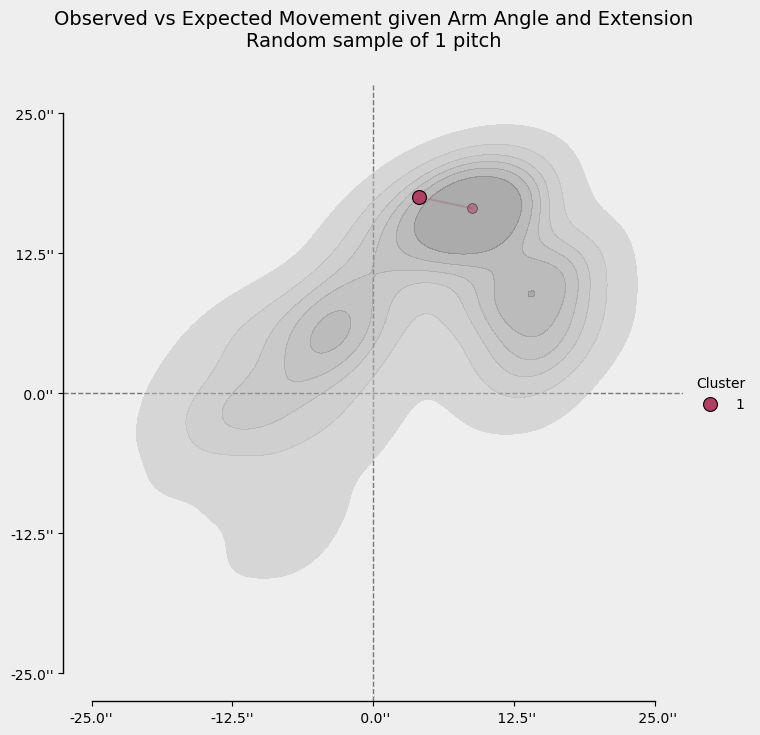

In [15]:
cluster_colors = {}
for i,key in enumerate(COLOR_DICT.keys()):
    cluster_colors[i]=COLOR_DICT[key]

from matplotlib.colors import LinearSegmentedColormap
import matplotlib

fig, ax = plt.subplots(figsize=(8,8), facecolor="#eeeeee")
sample_size = 1
plot_data = df.query("""release_speed>=75""").sample(sample_size)

for idx, row in plot_data.iterrows():
    ax.plot(
        [row["horz"], row["pred_mu_horz"]], 
        [row["vert"], row["pred_mu_vert"]], 
        color=colors[row["pitch_cluster"]], 
        alpha=0.3, 
        linestyle="-", 
        zorder=1,
        label=None,
    ) 
    
    sns.scatterplot(
        x=[row["horz"]],
        y=[row["vert"]],
        color=cluster_colors[row["pitch_cluster"]],
        edgecolor="black",
        s=100,
        ax=ax,
        zorder=3,
        label=row["pitch_cluster"],
    )

    sns.scatterplot(
        x=[row["pred_mu_horz"]],
        y=[row["pred_mu_vert"]],
        color=cluster_colors[row["pitch_cluster"]],
        edgecolor="black",
        alpha=0.5,
        s=50,
        ax=ax,
        zorder=3,
        label=None,
    )
    
    big_x = []
    big_y = []
    for i, cluster in enumerate(df["pitch_cluster"].unique()):
        weight = row[f"cluster_{cluster}_pred"]
        random_sample = np.random.multivariate_normal(
            mean=[
                row[f"cluster_{cluster}_pred_mu_horz"],
                row[f"cluster_{cluster}_pred_mu_vert"]
            ],
            cov=[
                [row[f"cluster_{cluster}_pred_var_horz"], 
                 row[f"cluster_{cluster}_pred_corr_horz_vert"]],
                [row[f"cluster_{cluster}_pred_corr_horz_vert"],
                 row[f"cluster_{cluster}_pred_var_vert"]]
            ],
            size=int(weight*1000)
        )
        
        big_x.append(pd.Series(random_sample[:,0]))
        big_y.append(pd.Series(random_sample[:,1]))
    
    big_x = pd.concat(big_x).values
    big_y = pd.concat(big_y).values

    sns.kdeplot(
        x=big_x,
        y=big_y,
        fill=True,
        ax=ax,
        levels=7,
        linewidths=0,
        color="gray",
        alpha=0.5,
    )

ax.legend(loc="center left", bbox_to_anchor=(1,0.5), facecolor="#eeeeee", frameon=False,title="Cluster")
ticks = np.linspace(-25,25,5)
tick_labels = [f"""{tick: 0.1f}''""" for tick in ticks]
ax.set(
    facecolor="#eeeeee",
    xlim=(-27.5,27.5),
    ylim=(-27.5,27.5),
    xticks=ticks,
    yticks=ticks,
    xticklabels=tick_labels,
    yticklabels=tick_labels,
)

ax.axhline(0, color="black", lw=1, zorder=0, linestyle="--", alpha=0.5)
ax.axvline(0, color="black", lw=1, zorder=0, linestyle="--", alpha=0.5)
sns.despine()
ax.spines[["bottom","left"]].set_visible(True)
ax.spines[["bottom","left"]].set_color("black")
ax.spines[["bottom","left"]].set_linewidth(1)
ax.spines[["bottom","left"]].set_bounds(-25,25)
ax.set_title(
    f"""Observed vs Expected Movement given Arm Angle and Extension
Random sample of {sample_size} pitch""", 
    fontsize=14, 
    y=1.05,
)

plt.show()

In [16]:
from matplotlib.patches import Circle

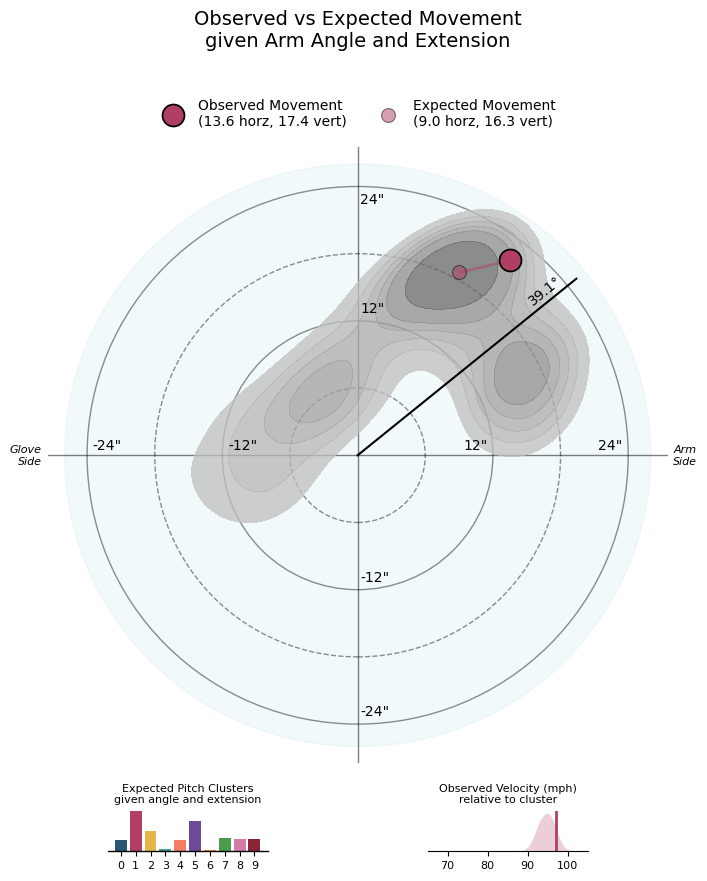

In [24]:
cluster_colors = {}
for i,key in enumerate(COLOR_DICT.keys()):
    cluster_colors[i]=COLOR_DICT[key]

from matplotlib.colors import LinearSegmentedColormap
import matplotlib

fig, ax = plt.subplots(figsize=(8,8), facecolor="white")
sample_size = 1
plot_data = df.query("""release_speed>=75""").sample(sample_size)

for idx, row in plot_data.iterrows():
    big_x = []
    big_y = []
    for i, cluster in enumerate(df["pitch_cluster"].unique()):
        weight = row[f"cluster_{cluster}_pred"]
        random_sample = np.random.multivariate_normal(
            mean=[
                row[f"cluster_{cluster}_pred_mu_horz"],
                row[f"cluster_{cluster}_pred_mu_vert"]
            ],
            cov=[
                [row[f"cluster_{cluster}_pred_var_horz"], 
                 row[f"cluster_{cluster}_pred_corr_horz_vert"]],
                [row[f"cluster_{cluster}_pred_corr_horz_vert"],
                 row[f"cluster_{cluster}_pred_var_vert"]]
            ],
            size=int(weight*1000)
        )
        
        big_x.append(pd.Series(random_sample[:,0]))
        big_y.append(pd.Series(random_sample[:,1]))
    
    big_x = pd.concat(big_x).values
    big_y = pd.concat(big_y).values

    sns.kdeplot(
        x=big_x,
        y=big_y,
        fill=True,
        ax=ax,
        levels=np.linspace(0.25,1,7),
        linewidths=0,
        color="gray",
        zorder=1,
        alpha=0.75,
    )

    ax.plot(
        [row["horz"], row["pred_mu_horz"]], 
        [row["vert"], row["pred_mu_vert"]], 
        color=colors[row["pitch_cluster"]], 
        lw=2, 
        zorder=1,
        alpha=0.5,
        label=None,
    ) 

    horz=row["horz"]
    vert=row["vert"]
    sns.scatterplot(
        x=[row["horz"]],
        y=[row["vert"]],
        color=cluster_colors[row["pitch_cluster"]],
        edgecolor="black",
        s=250,
        ax=ax,
        zorder=3,
        label=f"Observed Movement\n({horz:.1f} horz, {vert:.1f} vert)",
    )

    exp_horz=row["pred_mu_horz"]
    exp_vert=row["pred_mu_vert"]
    sns.scatterplot(
        x=[row["pred_mu_horz"]],
        y=[row["pred_mu_vert"]],
        color=cluster_colors[row["pitch_cluster"]],
        edgecolor="black",
        alpha=0.5,
        s=100,
        ax=ax,
        zorder=2,
        label=f"Expected Movement\n({exp_horz:.1f} horz, {exp_vert:.1f} vert)",
    )

    ax.plot(
        [0,25*np.cos(row["arm_angle_final"]*np.pi/180)],
        [0,25*np.sin(row["arm_angle_final"]*np.pi/180)],
        color="black",
    )
    ax.text(
        s=str(round(row["arm_angle_final"],1))+"°",
        x=19.25*np.cos(row["arm_angle_final"]*np.pi/180),
        y=21.25*np.sin(row["arm_angle_final"]*np.pi/180),
        rotation=row["arm_angle_final"],
    )

ax.legend(loc="upper center", bbox_to_anchor=(0.5,1.1),frameon=False,title="",ncols=2)
ticks = np.linspace(-25,25,5)
ax.set(
    facecolor="white",
    xlim=(-27.5,27.5),
    ylim=(-27.5,27.5),
    xticks=[],
    yticks=[],
)

ax.add_patch(
    Circle(
        (0, 0), 24, 
        fill=False, 
        color='black', 
        alpha=0.5, 
        zorder=0,
    )
)

ax.add_patch(
    Circle(
        (0, 0), 12, 
        fill=False, 
        color='black', 
        alpha=0.5, 
        zorder=0,
    )
)

ax.add_patch(
    Circle(
        (0, 0), 18, 
        fill=False, 
        color='black', 
        linestyle="--",
        alpha=0.5, 
        zorder=0,
    )
)

ax.add_patch(
    Circle(
        (0, 0), 6, 
        fill=False, 
        color='black', 
        linestyle="--",
        alpha=0.5, 
        zorder=0,
    )
)

ax.add_patch(
    Circle(
        (0, 0), 26, 
        fill=True, 
        color='lightblue', 
        alpha=0.15, 
        zorder=0,
    )
)

for tick in np.linspace(-24,24,5):
    if tick!=0:
        ax.text(
            s=f"""{int(tick)}\"""",
            x=0.25,
            y=tick + 0.5 if tick!=24 else tick-0.5,
            ha="left",
            va="bottom" if tick!=24 else "top",
        )
    
        ax.text(
            s=f"""{int(tick)}\"""",
            y=0.25,
            x=tick + 0.5 if tick<0 else tick-0.5,
            ha="right" if tick>0 else "left",
            va="bottom",
        )

ax.text(
    s="Arm\nSide",
    x=28,
    ha="left",
    y=0,
    va="center",
    fontsize=8,
    style="italic",
)

ax.text(
    s="Glove\nSide",
    x=-28,
    ha="right",
    y=0,
    va="center",
    fontsize=8,
    style="italic",
)

ax.axhline(0, color="black", lw=1, zorder=0, alpha=0.5)
ax.axvline(0, color="black", lw=1, zorder=0, alpha=0.5)
sns.despine(left=True,bottom=True)
ax.set_title(
    f"""Observed vs Expected Movement
given Arm Angle and Extension""", 
    fontsize=14, 
    y=1.15,
)

bar_ax = fig.add_axes([0.2,0.0,0.2,0.05])
bar_ax.bar(
    np.arange(10),
    plot_data[[col for col in plot_data.columns if col.startswith("cluster_") and col.endswith("_pred")]].mean(),
    color=[cluster_colors[key] for key in np.arange(10)]
)

bar_ax.set_facecolor("white")
bar_ax.tick_params(axis="x",color="black")

bar_ax.spines[["bottom"]].set_visible(True)
bar_ax.spines[["bottom"]].set_color('black')
bar_ax.spines[["bottom"]].set_linewidth(1)
bar_ax.spines[["top","left","right"]].set_visible(False)

bar_ax.set(
    ylim=[0,np.max(plot_data[[col for col in plot_data.columns if col.startswith("cluster_") and col.endswith("_pred")]].mean())],
    xticks=np.arange(10),
    yticks=[],
)
bar_ax.set_xticklabels(np.arange(10),fontsize=8)
bar_ax.set_title("Expected Pitch Clusters\ngiven angle and extension", color="black", fontsize=8)

kde_ax = fig.add_axes([0.6,0.0,0.2,0.05])
sns.kdeplot(
    data=df.loc[(df["pitch_cluster"]==plot_data["pitch_cluster"].values[0])],
    x="release_speed",
    color=cluster_colors[plot_data["pitch_cluster"].values[0]],
    fill=True,
    ax=kde_ax,
    alpha=0.25,
    lw=0.01,
)

kde_ax.axvline(plot_data["release_speed"].mean(),color=cluster_colors[plot_data["pitch_cluster"].values[0]],lw=2,)

kde_ax.spines[["top","left","right"]].set_visible(False)
kde_ax.set(
    ylabel="",
    yticks=[],
    xlim=[65,105],
    xticks=np.linspace(70,100,4),
    xlabel="",
)
x_labels=[str(int(mph)) for mph in np.linspace(70,100,4)]
kde_ax.set_xticklabels(x_labels,fontsize=8)
kde_ax.set_title("Observed Velocity (mph)\nrelative to cluster", color="black", fontsize=8)

plt.show()